# Project: Trump and Population Sentiment Over Coronavirus

__Author__: _Luheng (Wes) Wang_ , lw2534@nyu.edu, N10047237

<b>

<b>

<b>

## Part 1: Pre-step

President Trump's twitter has always been interesing, I can't find any other head of a country being this enthusiastic in communicating with the public through social media. Especially in a time like this, the Coronavirus seems to push him to express more than usual. Despite my personal political standing, I want to analyze the power of his unique way of communication, specifically upon the incident of COVID-19. I suggest that as the President of the US, what he says, writes, or posts ought to have certain linkage with the majority, or even causation. This project serves to see whether Trump's sentiment in tweets is associated with that of the general public. This project is political-neutral, or, doens't contain any political content. Please feel free to go on!

<b>

## Part 2: Data & Initial Analysis

There's no data ready for me to use, so I have to generate my own. This is a long process, and I will not be able to answer the four guideline questions until I reach the end of this section.

First things always, imports:

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import glob
import io
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from twitter_scraper import get_tweets
from tqdm import tqdm
import statsmodels.formula.api as sm


pd.set_option('display.max_columns', 50)

I will generate sentiment data for population and Trump separately. First, I believe that if I have a table of frequent vocabularies in COVID19-related tweets, I would be able to convert them into sentiment values. Fortunately, I found in Github that someone has generated those tables for the past two months. I will import them directly from the website and edit each of them a little.

In [2]:
# generate all dates which the github source I'm using has corresponding data,
# so that I can further insert them into urls

mar = []
for i in range(22,32):
    mar.append(str(i))
for i in range(len(mar)):
    mar[i] = '2020-03-' + mar[i]
apr = []
for i in range(1,31):
    if i < 10:
        apr.append('0' + str(i))
    else:
        apr.append(str(i))
for i in range(len(apr)):
    apr[i] = '2020-04-' + apr[i]
para = mar + apr

# generate urls to access those files

urls = []
for i in para:
    urls.append('https://raw.githubusercontent.com/thepanacealab/covid19_twitter/master/'\
                'dailies/' + i + '/' + i + '_top1000trigrams.csv')

# create a large dataframe with each day's count in separated columns,
# the datafram is created by joining data from each day.

df = pd.read_csv(urls[0])
df.rename(columns = {'counts' : para[0][-5:] +' counts'}, inplace = True)
# for some reason 38th iteration is giving http 404, so here I will just leave out the last two days
for i in tqdm(range(1,len(urls) - 2)):
    temp = pd.read_csv(urls[i])
    temp.rename(columns = {'counts' : para[i][-5:] +' counts'}, inplace = True)
    df = df.merge(temp, left_on='gram', right_on='gram', how = 'outer')

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:04<00:00,  7.41it/s]


In [3]:
# see what the dataframes are like to check the original dataframes are merged correctly

df_single = pd.read_csv(urls[0])
display(df.shape[0], df_single.shape[0],
       df.iloc[:,8], np.sum(df.iloc[:,8]),
       df.iloc[5000:5005,10], len(df.gram.unique()))


17509

1000

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
17504   NaN
17505   NaN
17506   NaN
17507   NaN
17508   NaN
Name: 03-29 counts, Length: 17509, dtype: float64

254912.0

5000    226.0
5001    224.0
5002    222.0
5003    221.0
5004    220.0
Name: 03-31 counts, dtype: float64

17509

In [4]:
# clean and format the df
# note that the datasets are pretty clean since they are well-generated by the github author 

df.fillna(0, inplace = True)
df.gram = [phrase.lower() for phrase in df.gram]
df.rename(columns = {'gram':'phrase'}, inplace = True)

# split the phrases into separate vocaabs so that we can calculate the sentiment more easily

vocab1 = [phrase.split()[0] for phrase in df.phrase]
vocab2 = [phrase.split()[1] for phrase in df.phrase]
vocab3 = [phrase.split()[2] for phrase in df.phrase]
df['vocab1'] = vocab1
df['vocab2'] = vocab2
df['vocab3'] = vocab3
col = list(df.columns.values)
col = col[-3:] + col[0:-3]
df = df[col]
df.head()

,vocab1,vocab2,vocab3,phrase,03-22 counts,03-23 counts,03-24 counts,03-25 counts,03-26 counts,03-27 counts,03-28 counts,03-29 counts,03-30 counts,03-31 counts,04-01 counts,04-02 counts,04-03 counts,04-04 counts,04-05 counts,04-06 counts,04-07 counts,04-08 counts,04-09 counts,04-10 counts,04-11 counts,04-12 counts,04-13 counts,04-14 counts,04-15 counts,04-16 counts,04-17 counts,04-18 counts,04-19 counts,04-20 counts,04-21 counts,04-22 counts,04-23 counts,04-24 counts,04-25 counts,04-26 counts,04-27 counts,04-28 counts
0,trying,times,share,trying times share,4249.0,1826.0,481.0,146.0,195.0,163.0,0.0,0.0,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,italy,trying,times,italy trying times,4229.0,1815.0,479.0,145.0,186.0,160.0,0.0,0.0,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,stand,italy,trying,stand italy trying,4228.0,1814.0,479.0,145.0,186.0,159.0,0.0,0.0,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,times,share,support,times share support,4223.0,1815.0,481.0,146.0,187.0,160.0,0.0,0.0,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,share,support,italian,share support italian,4217.0,1815.0,480.0,146.0,186.0,160.0,0.0,0.0,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Now let's inspect the df more closely
# check each phrases total appearances

df['countall'] = df.sum(axis = 1) 
df.head()

,vocab1,vocab2,vocab3,phrase,03-22 counts,03-23 counts,03-24 counts,03-25 counts,03-26 counts,03-27 counts,03-28 counts,03-29 counts,03-30 counts,03-31 counts,04-01 counts,04-02 counts,04-03 counts,04-04 counts,04-05 counts,04-06 counts,04-07 counts,04-08 counts,04-09 counts,04-10 counts,04-11 counts,04-12 counts,04-13 counts,04-14 counts,04-15 counts,04-16 counts,04-17 counts,04-18 counts,04-19 counts,04-20 counts,04-21 counts,04-22 counts,04-23 counts,04-24 counts,04-25 counts,04-26 counts,04-27 counts,04-28 counts,countall
0,trying,times,share,trying times share,4249.0,1826.0,481.0,146.0,195.0,163.0,0.0,0.0,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7272.0
1,italy,trying,times,italy trying times,4229.0,1815.0,479.0,145.0,186.0,160.0,0.0,0.0,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7226.0
2,stand,italy,trying,stand italy trying,4228.0,1814.0,479.0,145.0,186.0,159.0,0.0,0.0,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7223.0
3,times,share,support,times share support,4223.0,1815.0,481.0,146.0,187.0,160.0,0.0,0.0,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7223.0
4,share,support,italian,share support italian,4217.0,1815.0,480.0,146.0,186.0,160.0,0.0,0.0,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7215.0


Now that we have a well-generated dataframe with counts of each phrase in each day. As future data scientists, we ought to be asking ourselves questions most of the time. We observe here that the counts are pretty close to each other, which is not that likely. However, I have no way to inspect that, so I continue, assuming these numbers are accurate. Next step is to convert the numbers into sentiment day by day. I use the VADER sentiment from github, more detailed info is in the comment:

In [6]:
# get the sentiment sheet
# Note that this is obtained from 'https://github.com/cjhutto/vaderSentiment', it is called VADER sentiment
# It is mainly used to analyze the sentiment in social platforms, such as tweets

urllib.request.urlretrieve('https://raw.githubusercontent.com/cjhutto/vaderSentiment'\
                       '/master/vaderSentiment/vader_lexicon.txt', 'sentiment.txt')
with open('sentiment.txt') as f:
    a = f.readlines()
x = [line.split('\t') for line in a]
sent = pd.DataFrame(x).rename(columns = {0: 'tokens', 1: 'polarity'}).set_index('tokens')[['polarity']]
sent.polarity = pd.to_numeric(sent.polarity)
sent.head()

,polarity
tokens,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


In [7]:
# now I will calculate the in all sentiment value for each day
# note that it's very likely that the sentiment table doesn't contain some vocab
# I will set those to simply zero, assuming that the probability of the word being positive or negative is 0.5 (randomness)

sentiment_day = [0, 0, 0, 0]      # the first four columns excluded
for i in tqdm(range(4,len(df.columns)-1)):
    temp = 0
    for ii in range(len(df)):
        try:
            vocab_sent1 = float(sent.loc[df.iloc[ii,0]])
        except:
            vocab_sent1 = 0
        try:
            vocab_sent2 = float(sent.loc[df.iloc[ii,1]])
        except:
            vocab_sent2 = 0
        try:
            vocab_sent3 = float(sent.loc[df.iloc[ii,2]])
        except:
            vocab_sent3 = 0
        temp = temp + ((vocab_sent1 + vocab_sent2 + vocab_sent3) * df.iloc[ii,i])
    sentiment_day.append(temp)

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [06:58<00:00, 11.02s/it]


In [8]:
sentiment_day[:8]

[0,
 0,
 0,
 0,
 70754.50000000001,
 34562.40000000002,
 22050.30000000001,
 16914.500000000022]

In [9]:
# I notice that the above algorithm takes like 6 minutes which is not desireable,
# so instead of using multiprocessing, I decide to use the similar algorithm but coded in a more explicit way
# it is faster, the output senti_day is basically the same as sentiment_day from above,
# despite minor differences caused by different ways of calculation
# I will also leave the previous method, just to double check the results calculated are accurate

senti = []
senti_day = []
for i in tqdm(range(len(df))):
    try:
        s1 = float(sent.loc[df.iloc[i,0]])
    except:
        s1 = 0
    try:
        s2 = float(sent.loc[df.iloc[i,1]])
    except:
        s2 = 0
    try:
        s3 = float(sent.loc[df.iloc[i,2]])
    except:
        s3 = 0
    senti.append(s1+s2+s3)
for i in tqdm(range(4,len(df.columns)-1)):
    senti_day.append(np.sum(senti * df.iloc[:,i]))
senti_day = [0, 0, 0, 0] + senti_day

100%|█████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 614.54it/s]


In [10]:
senti_day[:8]

[0,
 0,
 0,
 0,
 70754.49999999999,
 34562.399999999994,
 22050.3,
 16914.499999999996]

In [11]:
# insert the result into the dataframe
# make the sum row at the top

temp = df.T
insert = senti_day + [0]     # the last column is excluded
temp['daily'] = insert
df = temp.T
df = df.iloc[np.arange(-1, len(df)-1)]
df.head()

,vocab1,vocab2,vocab3,phrase,03-22 counts,03-23 counts,03-24 counts,03-25 counts,03-26 counts,03-27 counts,03-28 counts,03-29 counts,03-30 counts,03-31 counts,04-01 counts,04-02 counts,04-03 counts,04-04 counts,04-05 counts,04-06 counts,04-07 counts,04-08 counts,04-09 counts,04-10 counts,04-11 counts,04-12 counts,04-13 counts,04-14 counts,04-15 counts,04-16 counts,04-17 counts,04-18 counts,04-19 counts,04-20 counts,04-21 counts,04-22 counts,04-23 counts,04-24 counts,04-25 counts,04-26 counts,04-27 counts,04-28 counts,countall
daily,0,0,0,0,70754.5,34562.4,22050.3,16914.5,-1885.5,38527.1,11684.1,2420,6985.8,6209.1,-14991.7,-4487,30995,-7351,14924.5,22043.5,2720.4,-13131.7,-4581.5,-19086.8,-24201.4,-8132.3,38882.6,8332.9,-2160,6750.9,-7906.5,6303.7,-5085.4,-31926.7,-18094.8,23486,1354.2,-35440.4,-35422.8,-19367.2,-23874,-30505,0
0,trying,times,share,trying times share,4249,1826,481,146,195,163,0,0,0,212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7272
1,italy,trying,times,italy trying times,4229,1815,479,145,186,160,0,0,0,212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7226
2,stand,italy,trying,stand italy trying,4228,1814,479,145,186,159,0,0,0,212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7223
3,times,share,support,times share support,4223,1815,481,146,187,160,0,0,0,211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7223


Now that I finally have the aggregated values of sentiment for each day, let's get Trump's data. I use a module called twitter_scraper which I found through searching Pypi. However, it seems to be unstable sometimes. I'm guessing that twitter have some sort of self-protective method to make these scrapers not functioning if they trigger some condition. So here I don't run the following cell everytime, I just use the csv file I downloaded for the first time:

In [ ]:
# now it's time to get Trump's tweets
# I'm using a method from github, it is a module called twitter_scraper
# Eventually I will save the tweets in a csv for further reading

tweets = [[]]
for tweet in get_tweets('realDonaldTrump', pages = 600):
    row = [tweet['text'], tweet['time'], tweet['likes']]
    tweets.append(row)

with open('tweet.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(tweets)
csvFile.close()

In [12]:
# read the csv file into a dataframe
# Noticed that somehow there's some werid entries at the end,
# the functions didn't seem to return the tweets in March
# So I will use only April tweets to do further analysis

trump = pd.read_csv('tweet.csv', header = None)
trump.head()

,0,1,2
0,Thank you Michael. You also! https://twitter.c...,2020-05-02 13:02:15,17608
1,"The FBI found ""no derogatory information"" abou...",2020-04-30 23:29:41,12313
2,The Russia Hoax is the biggest political scand...,2020-05-02 12:56:46,37419
3,Join me for a quick laugh about the funniest T...,2020-05-01 14:04:32,4992
4,This kill shot is so perfectly executed it is ...,2020-05-01 13:58:36,4917


In [13]:
# Clean the dataframe trump

trump.sort_values(1, inplace = True, ascending = False)
trump = trump[81:501]
trump.sort_values(1, inplace = True, ascending = True)
trump.reset_index(inplace = True)
trump.drop(['index', 2], axis = 1, inplace = True)
trump.rename(columns = {0 : 'tweet', 1 : 'date'}, inplace = True)
trump.date = trump.date.str[8:10]
trump.tweet = trump.tweet.str.lower()

In [14]:
# further manipulate the df so that I can apply sentiment df on each tweet

# convert the trump_sent df into tweet by date, and the tweets are in list-of-vocab form

trump_sent = trump.groupby('date')['tweet'].unique().str.join(' ').reset_index()
for i in range(len(trump_sent.tweet)):
    temp = re.sub('[^a-z0-9]+', ' ', trump_sent.iloc[i,1])
    temp = temp.split(' ')
    trump_sent.iloc[i,1] = temp

In [15]:
# generate Trump's sentiment, basically the same method as with the population sentiment

trump_daily = []
for i in tqdm(range(len(trump_sent))):
    temp = 0
    for ii in trump_sent.iloc[i,1]:
        try:
            temp = temp + float(sent.loc[ii])
        except:
            continue
    trump_daily.append(temp)
trump_sent['sent'] = trump_daily
trump_sent.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 11.93it/s]


,date,tweet,sent
0,01,"[hydroxychloroquine, proving, an, effective, t...",2.1
1,02,"[exclusive, realdonaldtrump, s, campaign, has,...",-1.3
2,03,"[psalm, 33, 18, 20, but, the, lord, watches, o...",11.5
3,04,"[my, latest, colum, for, thehill, how, deadly,...",17.9
4,05,"[pic, twitter, com, wxqib5br4z, thank, you, to...",20.6


Now that I have both Trump's and population's sentiment for each day, I need to combine them to have the final usable table:

In [16]:
# Combine the population sentiment list with the trump sentiment list to produce our final table

final = pd.DataFrame(senti_day[14:], trump_daily)
final = final.reset_index()
final.rename(columns = {0:'Population', 'index':'Trump'}, inplace = True)
final['Date'] = trump_sent.date
# final.Trump = final.Trump.abs()
final.head()

,Trump,Population,Date
0,2.1,-14991.7,01
1,-1.3,-4487.0,02
2,11.5,30995.0,03
3,17.9,-7351.0,04
4,20.6,14924.5,05


Eventually, I have the data I need. As discussed above, looking for and generating the data is quite a long journey! The independent vaariable I will use is Trump's sentiment (Trump in the df), while the dependent variable is Population sentiment(Population in the df). For eaach entry (row) in the df, it represents on a specific day, the values for Trump's and Population's sentiment.

If I could change the dataset in one way, I would make it divided by 12 hours instead of by day, or even smaller amount of time, such as Morning, Afternoon, Evening, and Midnight, etc.. In this way, I can inspect more closely the association. Also, right now if Trump post a tweet near midnight, the reaction of the public (vise versa) will be in the next day's data, which cause the association we want to test not accurate.

<b>

## Part 3: Visualization

Scatter plot is typically suitable for 2-D dataset. Here I choose scatter plot to see the general association of the sentiment. For example, I want to see whether they share positive or negative relation, or no relation at all.

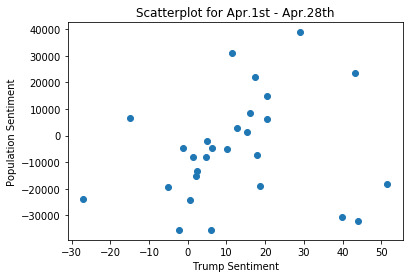

In [17]:
# first generate a normal scatter plot to see the general trend
# it appears kinda positive

plt.scatter(final.Trump, final.Population)
plt.title(f'Scatterplot for Apr.1st - Apr.28th')
plt.xlabel('Trump Sentiment')
plt.ylabel('Population Sentiment')
plt.show()

In the graph, I can see a general positive trend, but with some outliers at the bottom right corner. They indicate that Trump is very happy while the population is very unhappy. It seems interesting and one can go on and study those three days to see why, but to focus on my goal, here I will not follow that path.

Next I want to see if the two variables share synchronous relationship, ie, if they increase or decrease at the same time. So I choose line plot, which is great for data through time.

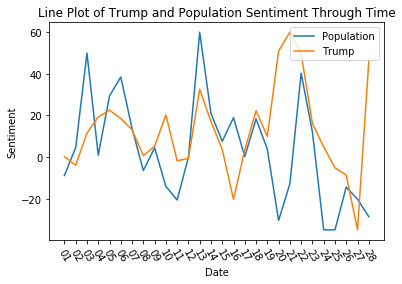

In [18]:
# next, scale the data with sklearn

final_scaled = final.copy()
final_scaled.Trump = preprocessing.minmax_scale(final.Trump, feature_range = (-35, 60))
final_scaled.Population = preprocessing.minmax_scale(final.Population, feature_range = (-35, 60))

plt.plot(final_scaled.Date, final_scaled.Population)
plt.plot(final_scaled.Date, final_scaled.Trump)
#plt.scatter(final_scaled.Date, final_scaled.Population, c = final_scaled.Trump)
plt.title('Line Plot of Trump and Population Sentiment Through Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.gca().legend(('Population','Trump'), loc = 'upper right')
plt.xticks(rotation = -60)
plt.show()

In the graph, I can see that Trump is more "steady" than the population, meaning that his line go up and down without much fluctuation. However, the population is opposite. When Trump's line increase over a period, the population line could be increase then decrease then increase (such as from 02 to 05). It has more fluctuation. In general, althought not explicit, I believe one can conclude that they are synchronous.

<b>

## Part 4: Hypothesis Forming

#### Variables

* _Independent_ : Trump's Sentiment, how to measure was discussed in Part 2
* _Dependent_ : Population's sentiment, how to measure was discussed in Part 2

#### Correlation Coefficient

In [19]:
correlation_matrix = final_scaled[['Trump','Population']].corr()
corr = correlation_matrix.iloc[1,0]
corr

0.17152127375453718

There is 17.15% correlation, which is lower than what I expected. However, it still shows a weak uphill (positive) linear relationship.

#### Regression Equation

I'm using the basic linear regression as I only have one independent variable, and the plot doesn't seem to show a non-linear relationship

<center>Population Sentiment $ = $ $\beta_0$ + $\beta_1$ $\times$ Trump sentiment<center>

* **$\beta_0$** is the intercept, ie. when Trump has no sentiment, the value of public sentiment.
* **$\beta_1$** is the gradient, ie. how the dependent vaariable in/decrease according to the independent variable.

#### Null and Alternative Hypothesis

* **$H_0$**: $\beta_1 = 0$   (Trump's Twitter sentiment has _**NO**_ effect on population Corona-related sentiment)
* **$H_A$**: $\beta_1 \neq 0$   (Trump's Twitter sentiment has _**CERTAIN**_ effect on population Corona-related sentiment)

<B>

## Part 5: Regression Analysis

First, get all the stats from the module statsmodels:

In [20]:
stats_result = sm.ols(formula = 'Population ~ Trump', data = final_scaled).fit()
print(stats_result.summary())

                            OLS Regression Results                            
Dep. Variable:             Population   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7881
Date:                Sun, 03 May 2020   Prob (F-statistic):              0.383
Time:                        18:21:35   Log-Likelihood:                -129.07
No. Observations:                  28   AIC:                             262.1
Df Residuals:                      26   BIC:                             264.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9189      5.556      0.165      0.8

#### Coefficients

* $\beta_0 = 0.9189$ 
* $\beta_1 = 0.2017$

The intercept indicates that when Trump has no sentiment (Trump = 0), the public sentiment is also very close to zero as well, 0.9189. The gradient indicates that with each 1 unit of increase/decrease in Trump's sentiment, the public sentiment increase/decrease by 0.2017 unit.

*  $for$ $\beta_1,$ $P>|t| = 0.383$

This indicates that when the null hyptothesis is true, we have 0.383 chance that our test statistics is higher than that we got for $\beta_1$. In the language of bootstrap sampling, this roughly corresponds to generating 1 thousand simulated datasets, and seeing 383 with a test statistic this extreme.

#### 95% CI for $\beta_1$

* $[-0.265,0.669]$

This means that if we repeatedly sampled Trump sentiment and Population sentiment data over and over again, we'd expect that 95% of the time the mean value of $\beta_1$ of these samples would lie between -0.265 and 0.669.

$R^2$

* $0.029$

This indicates that 2.9% of the variation in public sentiment is explained by the sentiment of Trump. It also tells us that the data doesn't fit our model that well, ie, they are not close to the best fit line enough.

#### Plot

Finally, we see the regplot by seaborn:

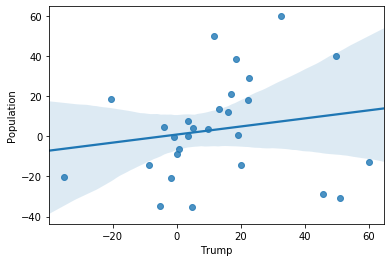

In [21]:
sns.regplot(x = 'Trump', y = 'Population', data = final_scaled)
plt.show()

#### Test Result

Since the p=value is larger than 0.05, I fail to reject the null hypothesis. So there's no apparent associaation between Trump's twitter sentiment and population sentiment. This might not be a good sign for his reelection, just kidding!

#### Residual Plot

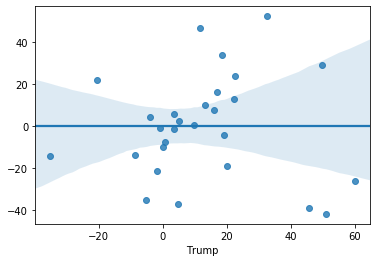

In [22]:
sns.regplot(x = 'Trump', y = stats_result.resid, data = final_scaled)
plt.show()

Here we see that the points are pretty random -- they are all over the place, without explicit positive or negative trend. There's no sign for heteroskedasticity. This means that my statistical inference and model is valid.

<b>

## Part 6: Conclusion

#### Bias

First, as mentioned earlier, I failed to get the data divided with more precise period of time, such as by half a day or morning, afternoon and so on. The trend might be different with smaller time window, and the increase/decrease of the two variable might be more synchronous. Second, the population dataset was actually collected by a thrid party. Although I don't know the detailed process, they are unlikely to collect every related tweet and produce the gram frequency table. For example, Elon Musk several days ago tweeted "FREE AMERICA NOW", if afterwards someone tweets saying "Hell No!"/"Hell Yes!" as a reply to his tweet but without direct retweeting or commenting, I don't think the latter tweet would be collected as it has no direct link to Coronavirus. I believe machine learning algorithms are not able to correctly classify these two words. So that is to say, unless with human inspection (may fail also), the dataset could be reflecting only a part of the population sentiment. The true association would've been different.

#### Test Conclusion

Following principles of the test, I believe there is no apparent link between Trump's twitter sentiment and the general population's twitter sentiment.

#### Weakness of The Project

* As mentioned quite a few times earlier, the division of time is not perfect.
* I assume that the vocabs that are not in sent df have sentiment zero, but that is a limitation of VADER sentiment.
* VADER sentiment might not be accurate. For example, what's the sentiment of "Hell" as in "Hell Yes!"?
* I selected all Trump's twitter from 4/1 to 4/28. Perhaps the tweets of his that is not related to COVID-19 is what cause our test to be not rejected. That needs further evaluation.
* I only selected April due to the limitation of datasets, however, things could've been different with wider data range
*